In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df_an = pd.read_csv('data/valve2/0.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)
df_an_fr = pd.read_csv('data/anomaly-free/anomaly-free.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)
healthy_pref_len = 400
healthy_prefix = df_an[:healthy_pref_len]

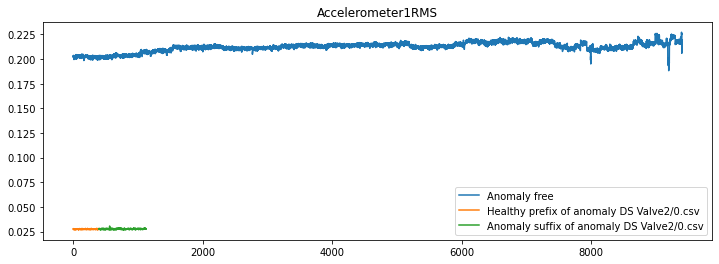

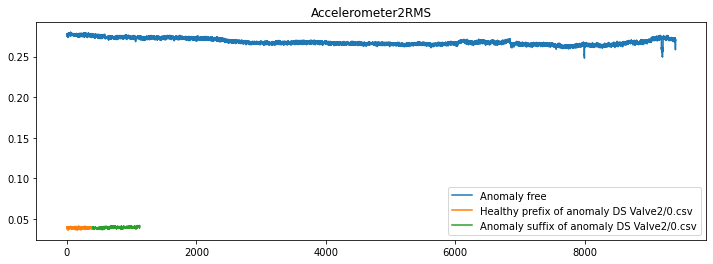

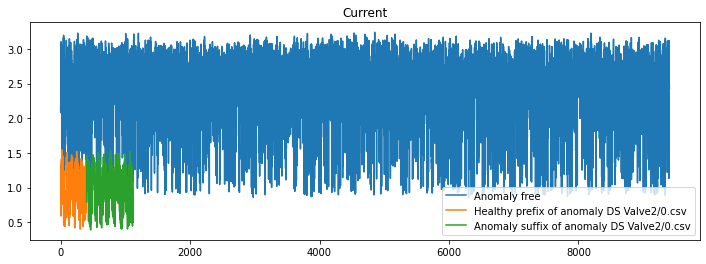

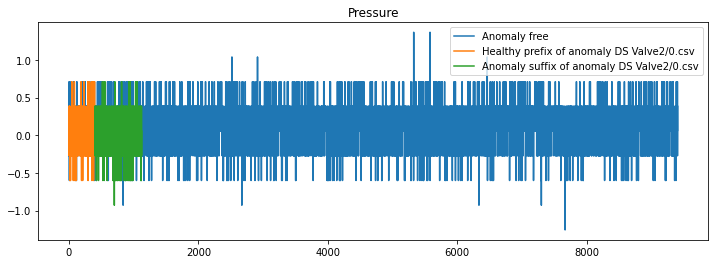

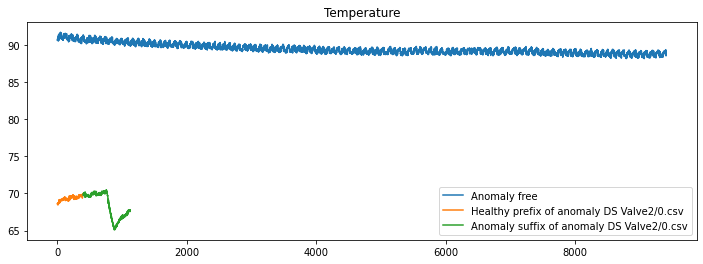

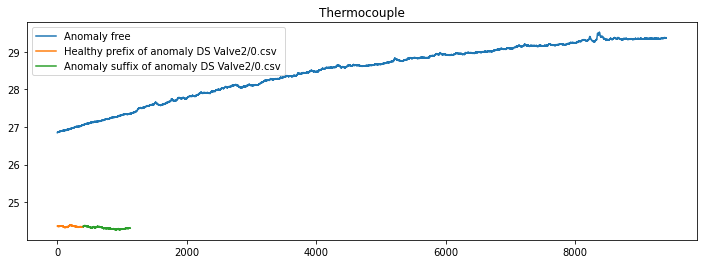

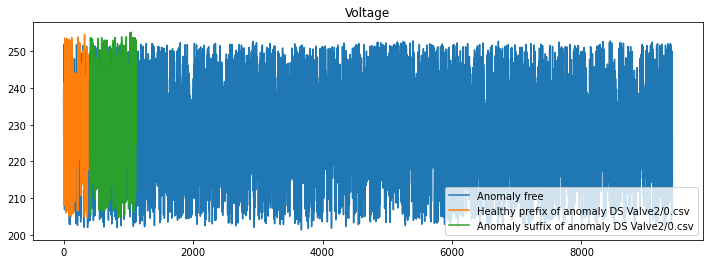

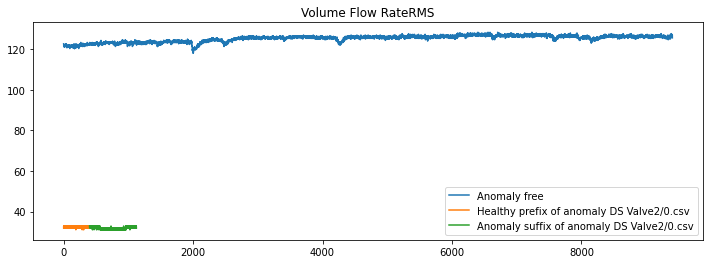

In [88]:
# anomalies_indecies = y.index[y == 1]

for c in df_an_fr.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df_an_fr[c].values)
    
    with_anoml = pd.Series(df_an[c].values)
    healthy_prefix = with_anoml[:healthy_pref_len]
    rest = with_anoml[healthy_pref_len:]
    plt.plot(healthy_prefix)
    plt.plot(rest)
    
    plt.legend(["Anomaly free ", "Healthy prefix of anomaly DS Valve2/0.csv", "Anomaly suffix of anomaly DS Valve2/0.csv"])
    plt.title(c)
    plt.show()

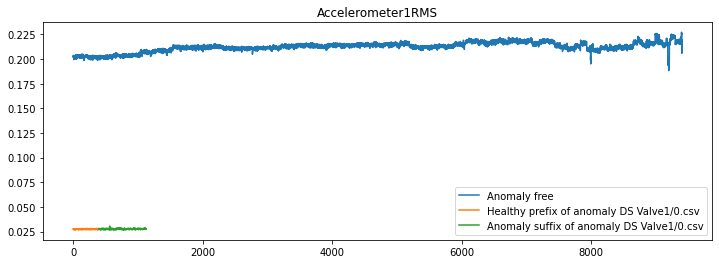

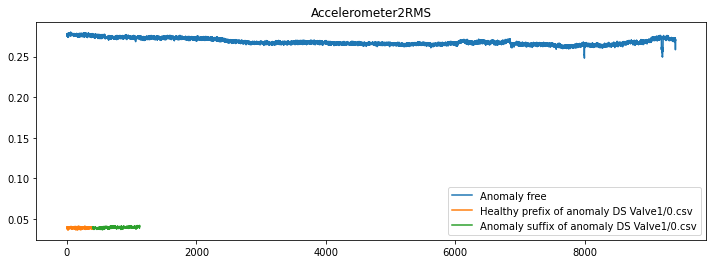

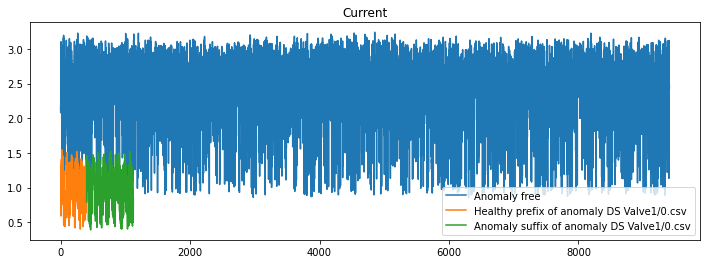

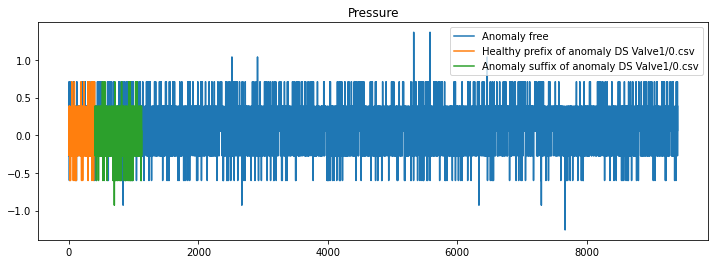

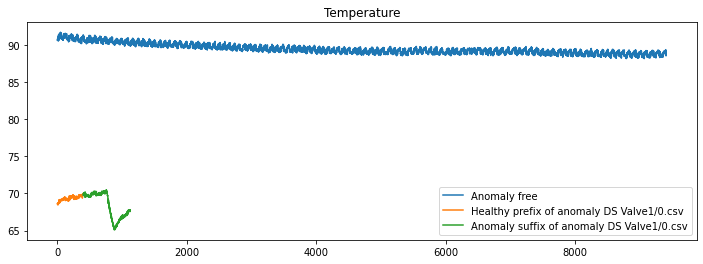

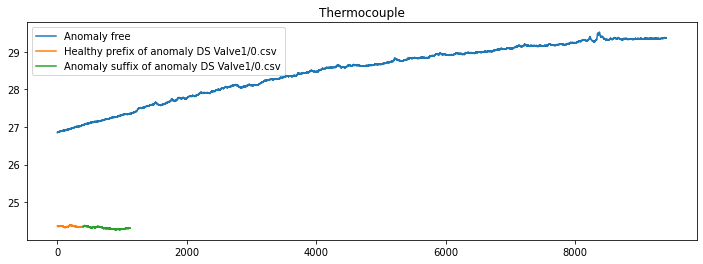

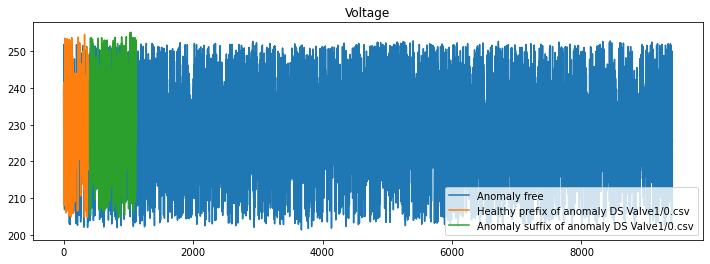

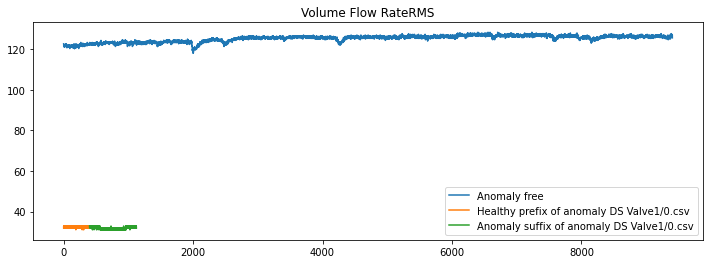

In [89]:
df_an = pd.read_csv('data/valve2/0.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)
# anomalies_indecies = y.index[y == 1]

for c in df_an_fr.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df_an_fr[c].values)
    
    with_anoml = pd.Series(df_an[c].values)
    healthy_prefix = with_anoml[:healthy_pref_len]
    rest = with_anoml[healthy_pref_len:]
    plt.plot(healthy_prefix)
    plt.plot(rest)
    
    plt.legend(["Anomaly free ", "Healthy prefix of anomaly DS Valve1/0.csv", "Anomaly suffix of anomaly DS Valve1/0.csv"])
    plt.title(c)
    plt.show()

### Вывод
Данные из anomaly-free сильно отличаются от здоровых данных из valve-1 и valve-2 из-за того, что насос не нагрелся.

Решение: Попробуем профдифференцировать

История:
Сначала продифференцировали (diff()). Все графики стали выглядеть как белый шум, даже на тех отрезках, где функция сильно возрастала и убывала. Предположили что это может быть из-за того, что интервал дифференцирования был слишком маленьким ( = 1), поэтому изменение функции было незначительным. Увелечили интервал дифференцирования (p).

Интервал дифференцирования - это отрезок, на концах которого вычисляется дельта функции.

Отрезки, на которых функция сильно возрастала и убывала стали хорошо отличимы от всего остального.
При этом дисперсия anomaly-free датасета была больше чем anomaly-датасета по некотрым признакам.
Хотим чтобы эти временные ряды были похожи. Как привести их к одному масштабу? Средние обоих рядов уже примерно равны нулю. Попробовали поделить каждый ряд на его std. Так как, аномалия(сильное отклонение от среднего) увеличивает std, std аномального ряда получилась больше чем std anomaly-free датасета. Следовательно, при делении на std, график аномального ряда получился более сжатым.

Тогда поделили аномальный ряд на std его здорового префикса. Получили соизмеримые дисперсии. 

Заметили что в anomaly-free по некоторым признакам есть тренды (Например thermocouple постепенно возрастает). Но при дифференцировании (diff()) получался белый шум, на котором, конечно, никаких трендов нельзя отметить. Поэтому увелечили интервал дифференцирования (p) и для этого датасета тоже.




In [103]:
df_an = pd.read_csv('data/valve2/0.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)

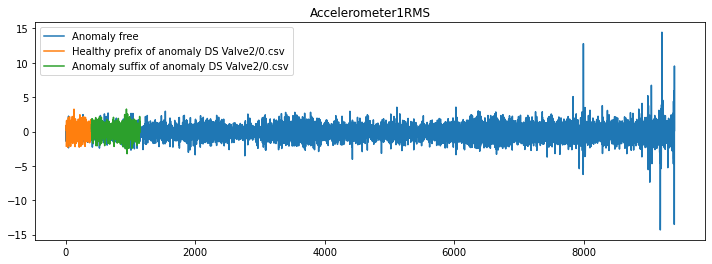

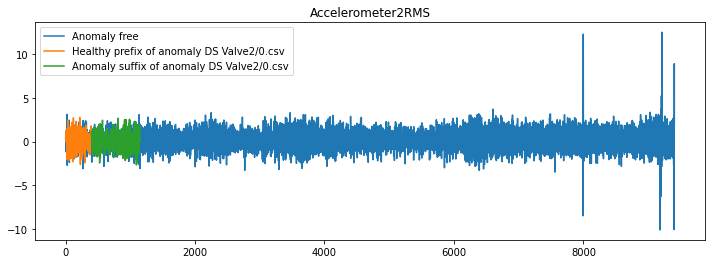

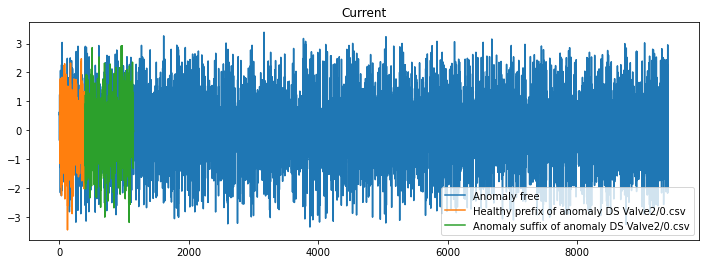

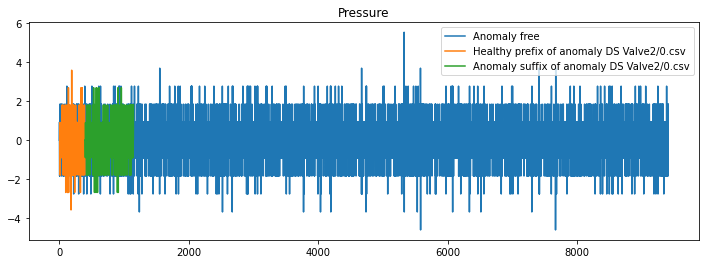

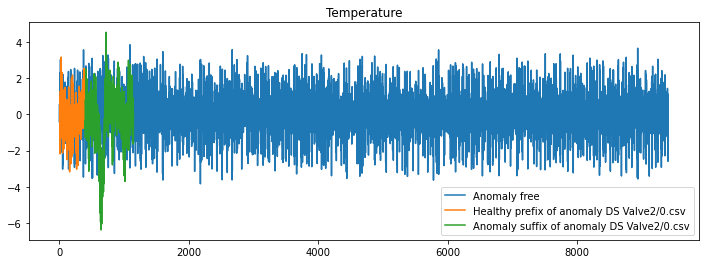

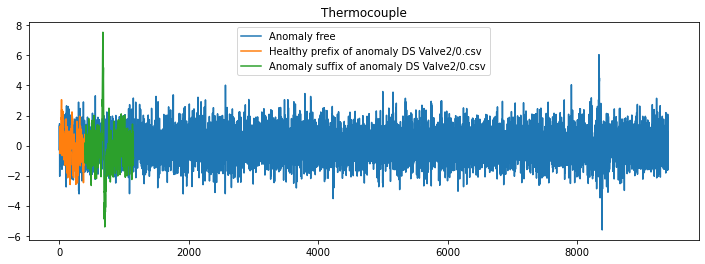

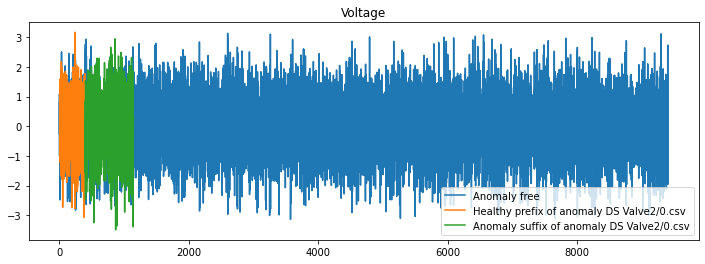

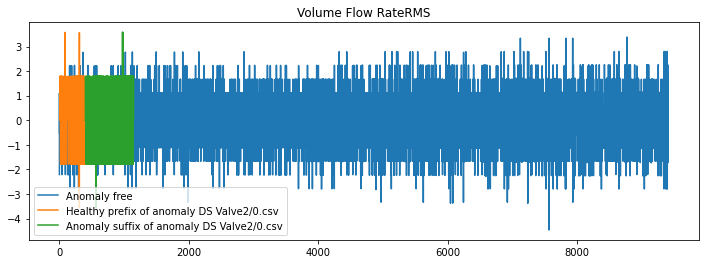

In [109]:
from sklearn.preprocessing import StandardScaler

p = 10 #periods. delta t. 
for c in df_an_fr.columns:
    plt.figure(figsize=(12,4))
    an_fr_d =pd.Series(df_an_fr[c].values).diff(periods = 2)
    an_fr_d=an_fr_d/an_fr_d.std()
    plt.plot(an_fr_d)# anomaly_free
    
    an_d = pd.Series(df_an[c].diff(periods = p).values)
    healthy_pref_std = an_d[:healthy_pref_len].std()
    an_d = an_d / healthy_pref_std
    
    healthy_prefix = an_d[:healthy_pref_len]
    plt.plot(healthy_prefix)# healthy prefix from anomaly df
    
    rest = an_d[healthy_pref_len:]
    plt.plot(rest)
    
    plt.legend(["Anomaly free", "Healthy prefix of anomaly DS Valve2/0.csv", "Anomaly suffix of anomaly DS Valve2/0.csv"])
    plt.title(c)
    plt.show()

In [116]:
df_an = pd.read_csv('data/valve1/3.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)

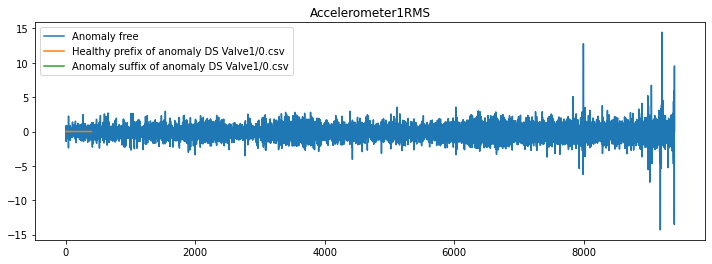

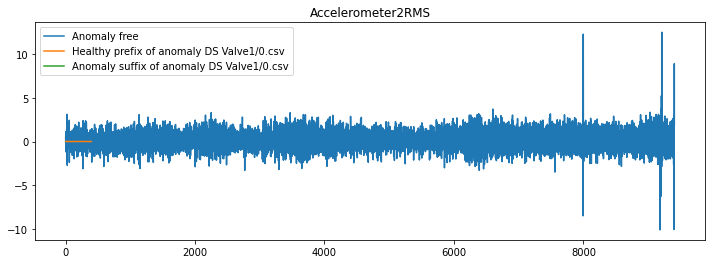

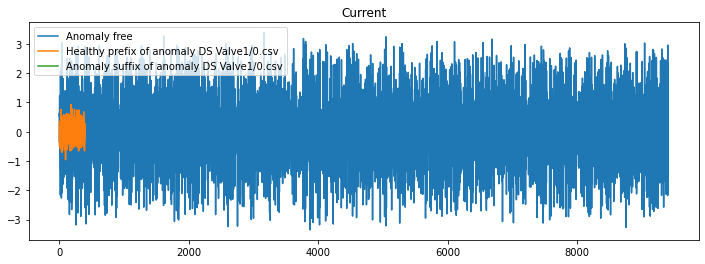

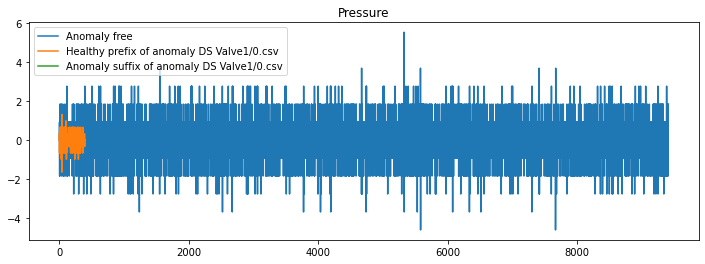

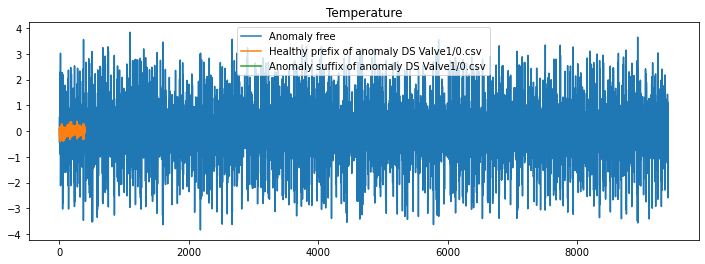

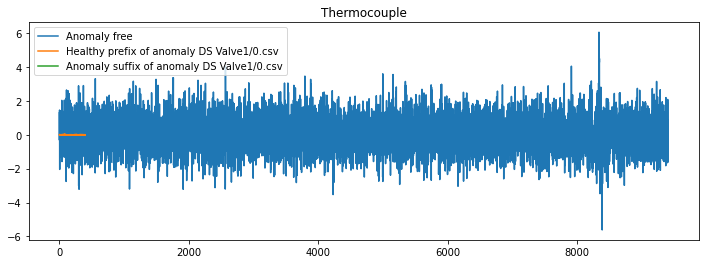

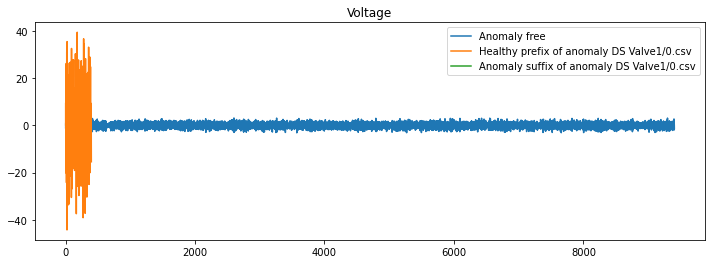

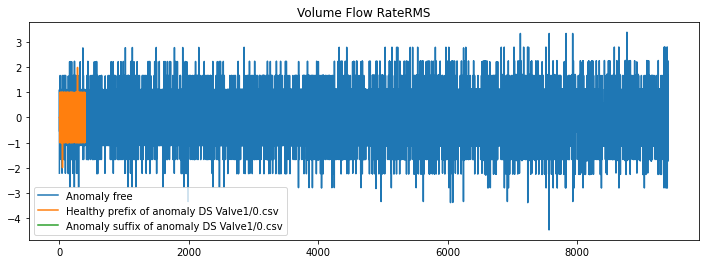

In [127]:
from sklearn.preprocessing import StandardScaler

p1 = 2 #periods. delta t. 
p2 = 10
for c in df_an_fr.columns:
    plt.figure(figsize=(12,4))
    an_fr_d =pd.Series(df_an_fr[c].values).diff(periods = 2)
    an_fr_d=an_fr_d/an_fr_d.std()
    plt.plot(an_fr_d)# anomaly_free
    
    # an_d = pd.Series(df_an[c].diff(periods = p).values)
    healthy_df_an_d = df_an[c][:healthy_pref_len].diff(periods = p1).values
    healthy_pref_std = healthy_df_an_d.std()
    
    rest_d = df_an[c][healthy_pref_len:].diff(periods = p2).values
    # an_d = healthy_df_an_d / healthy_pref_std
    
    healthy_prefix = healthy_df_an_d
    plt.plot(healthy_prefix)# healthy prefix from anomaly df
    
    rest = rest_d / healthy_pref_std
    plt.plot(rest)
    
    plt.legend(["Anomaly free", "Healthy prefix of anomaly DS Valve1/0.csv", "Anomaly suffix of anomaly DS Valve1/0.csv"])
    plt.title(c)
    plt.show()

<br></br>
### Насколько похожи здоровые префиксы в разных запусках одного эксперимента? (Для 2 подхода)

2 подход - train - 0.csv; test - остальные файлы.

https://github.com/waico/SKAB/issues/9

### Valve 1

In [90]:
from utils.data import load_df, load_df_with_names


In [7]:
list_of_df, _, file_names = load_df_with_names("./data/", "valve1")
file_names

['./data/valve1\\0.csv',
 './data/valve1\\1.csv',
 './data/valve1\\10.csv',
 './data/valve1\\11.csv',
 './data/valve1\\12.csv',
 './data/valve1\\13.csv',
 './data/valve1\\14.csv',
 './data/valve1\\15.csv',
 './data/valve1\\2.csv',
 './data/valve1\\3.csv',
 './data/valve1\\4.csv',
 './data/valve1\\5.csv',
 './data/valve1\\6.csv',
 './data/valve1\\7.csv',
 './data/valve1\\8.csv',
 './data/valve1\\9.csv']

In [8]:
features = list_of_df[0].columns
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

In [9]:
features

['Accelerometer1RMS',
 'Accelerometer2RMS',
 'Current',
 'Pressure',
 'Temperature',
 'Thermocouple',
 'Voltage',
 'Volume Flow RateRMS']

In [10]:
def get_healthy_prefix_len(df): return df.index.get_loc(df[df.anomaly==1].index[0])

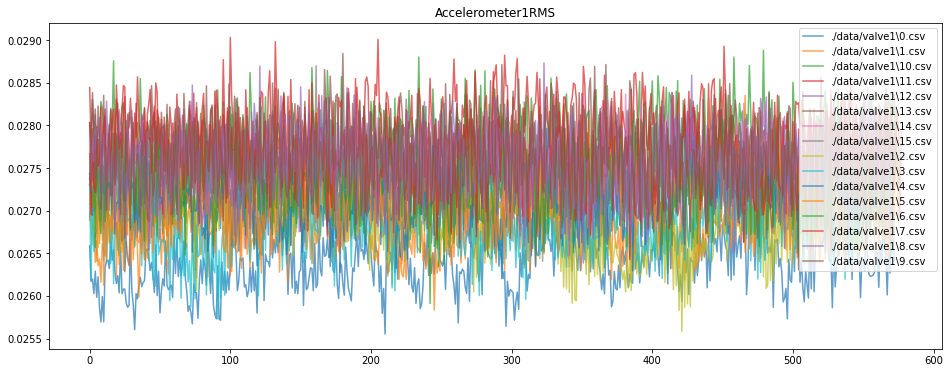

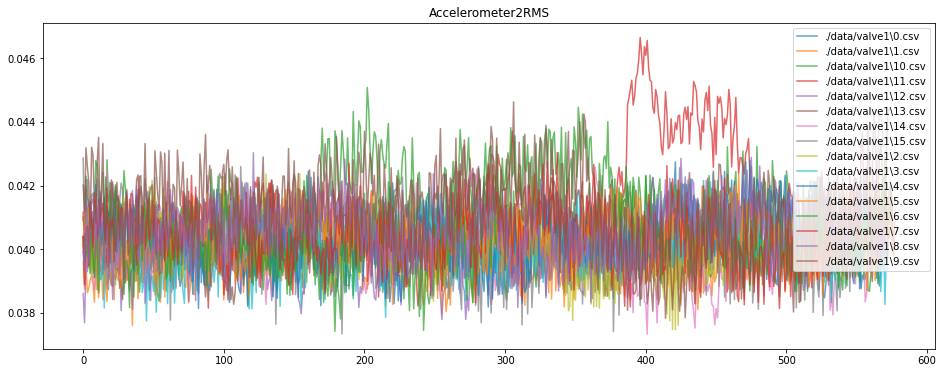

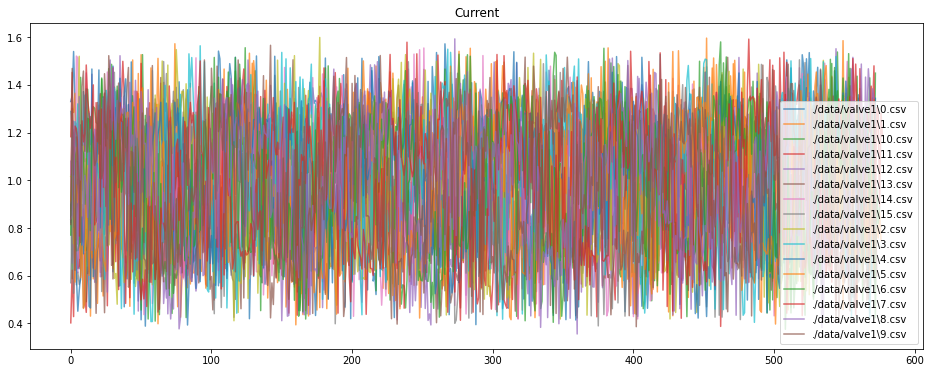

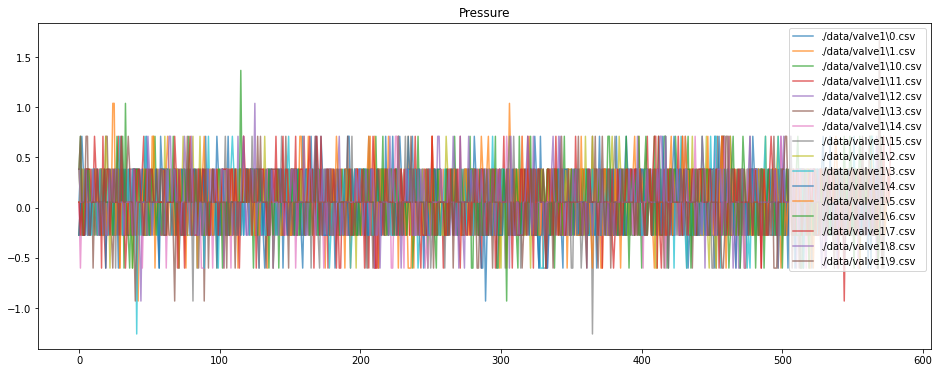

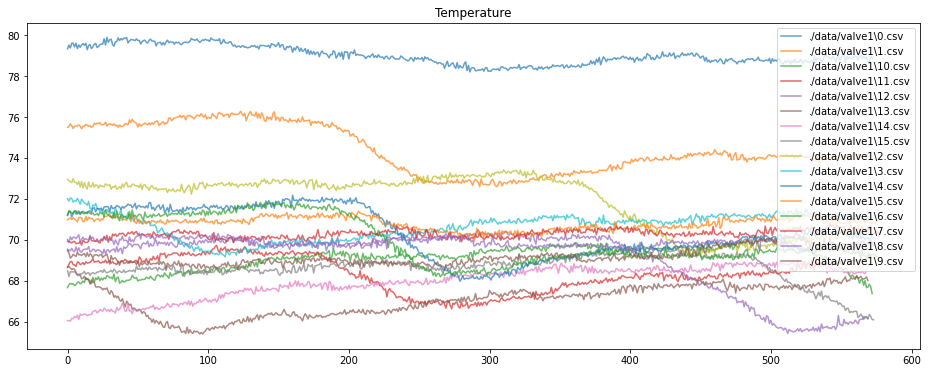

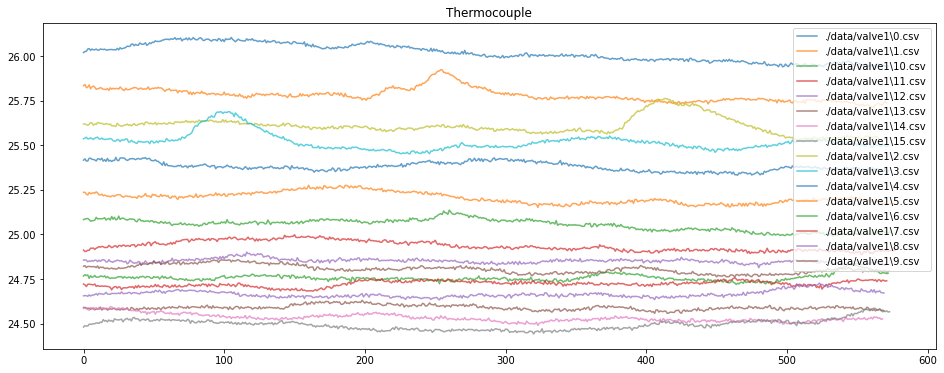

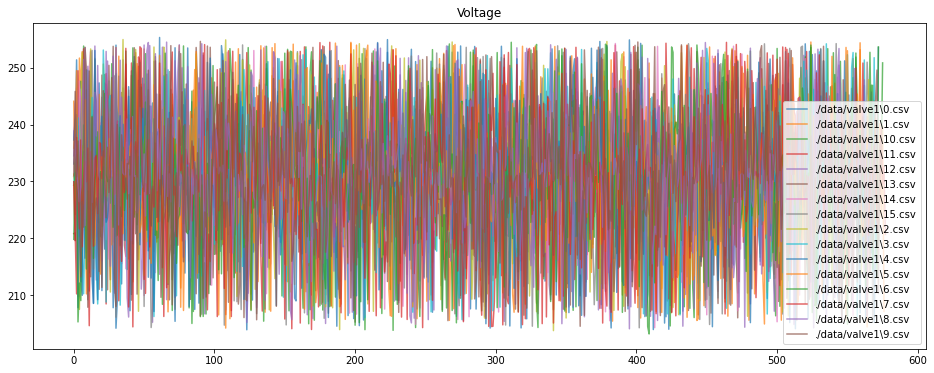

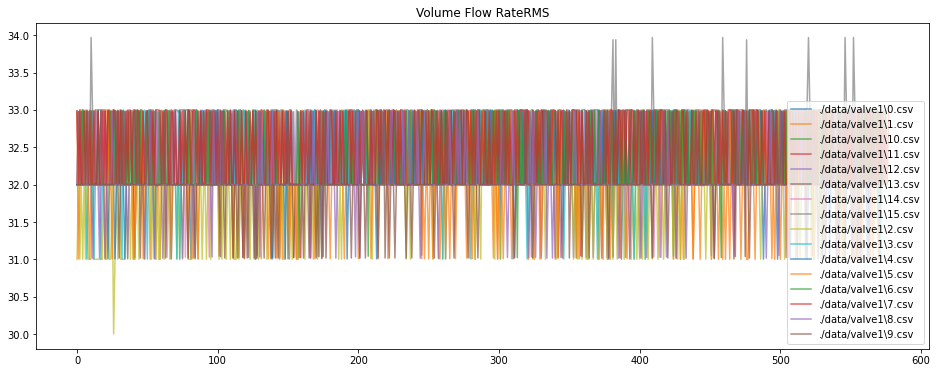

In [11]:
for feature in features:
    fig, ax = plt.subplots(figsize=(16,6))
    for df in list_of_df:
        prefix_len = get_healthy_prefix_len(df)        
        ax.plot(df[feature].values[:prefix_len], alpha=0.7)
        ax.set_title(feature)
        ax.legend(file_names)
    plt.show()

### Промежуточный вывод: Здоровые данные могут отличатьсся на 10-15%

Продифференцируем

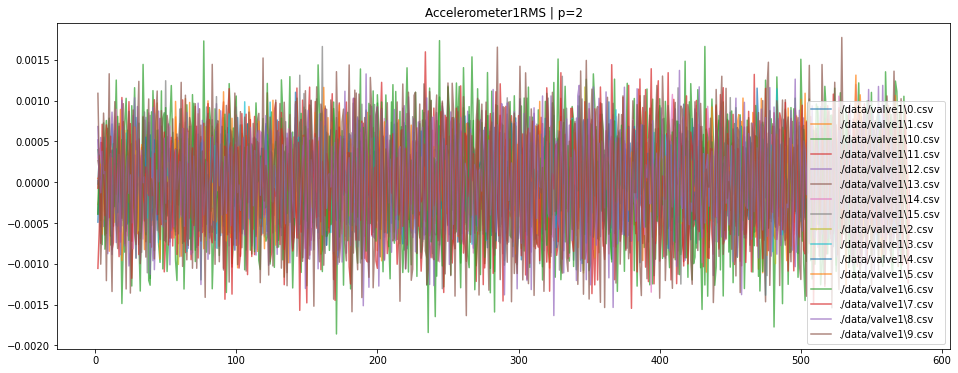

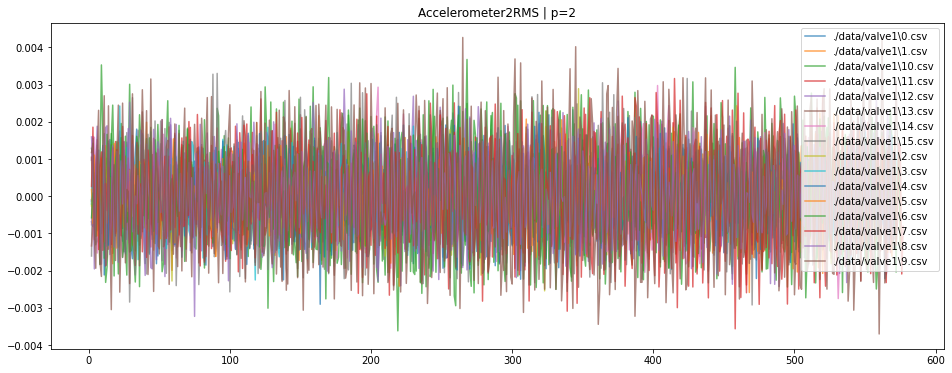

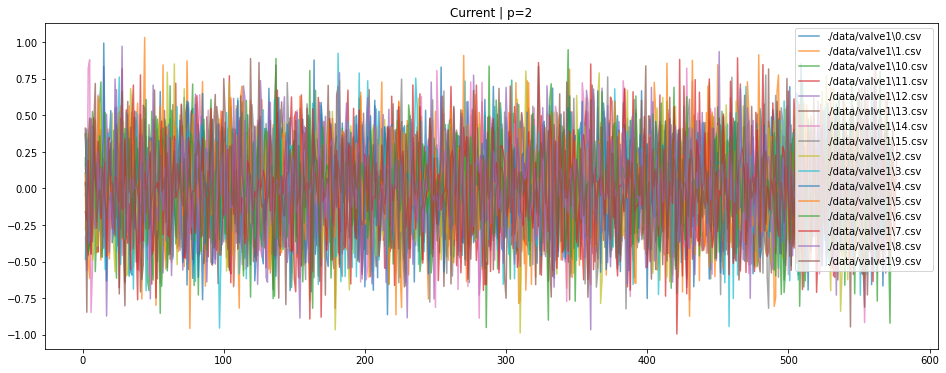

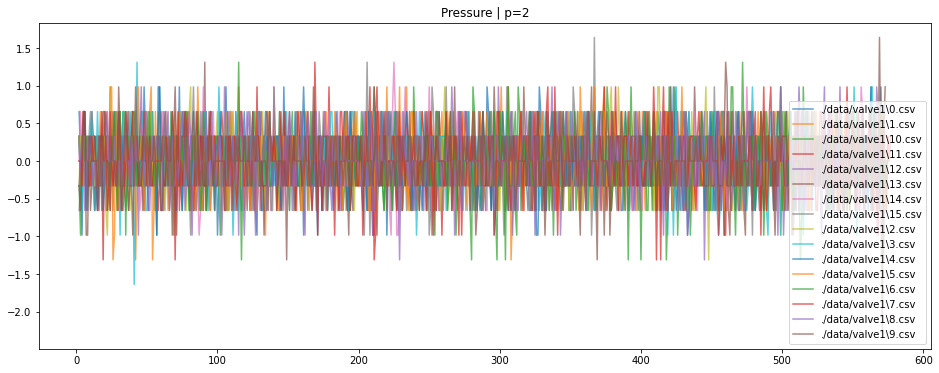

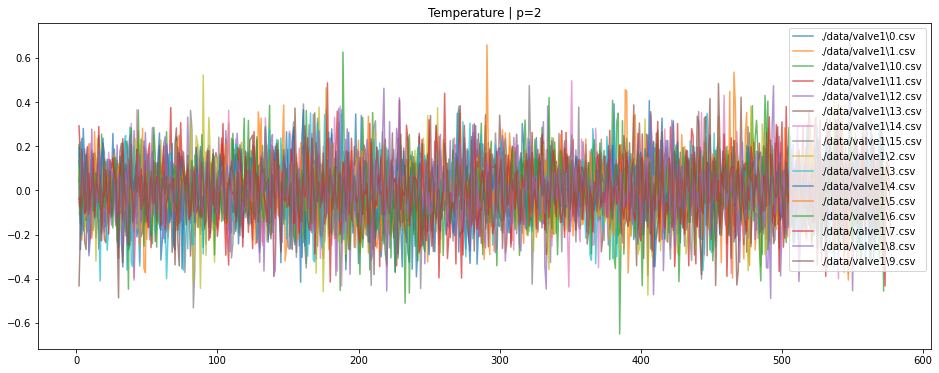

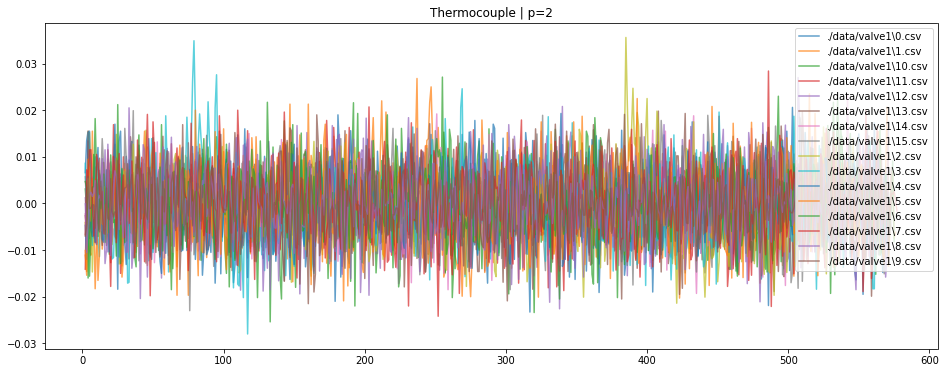

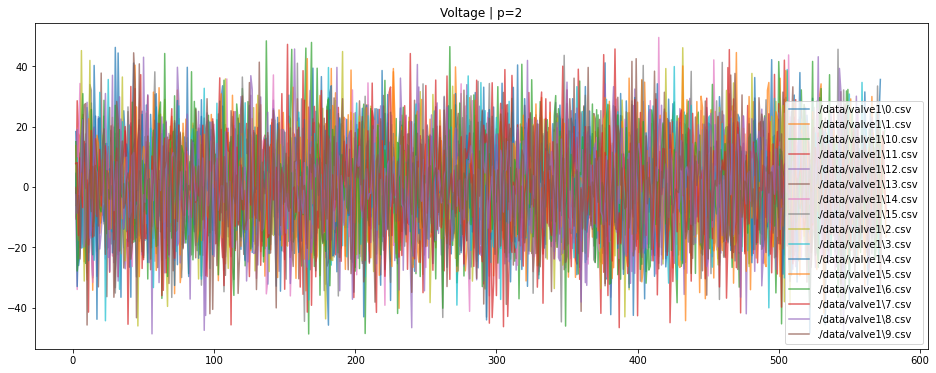

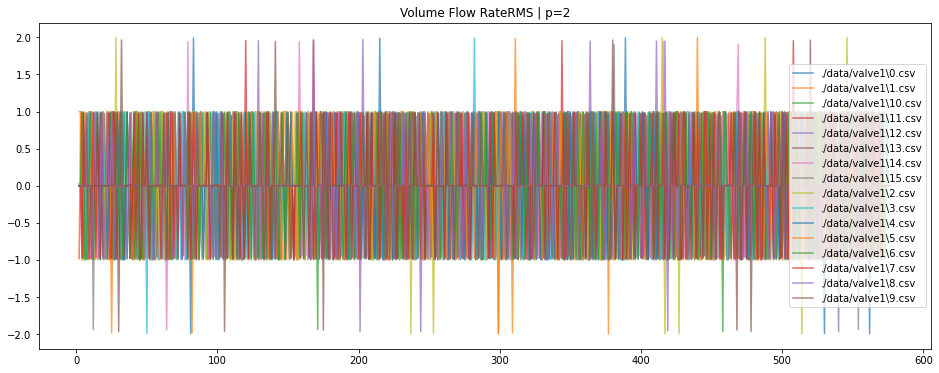

In [122]:

p = 2
for feature in features:
    fig, ax = plt.subplots(figsize=(16,6))
    for df in list_of_df:
        prefix_len = get_healthy_prefix_len(df)        
        ax.plot((df[feature].diff(periods = p).values[:prefix_len]), alpha=0.7)
        ax.set_title(f"{feature} | p={p}")
        ax.legend(file_names)
    plt.show()

### Вывод: Помогло

Дифференцирование позволило избавиться 